In [1]:
import torch
import matplotlib.pyplot as plt
from decimal import Decimal

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from nuscenes.nuscenes import NuScenes
from torchmetrics.detection import IntersectionOverUnion

import os
from get_2D_boxes_from_sample_data import get_2D_boxes_from_sample_data
import json 

In [2]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(img):
    plt.figure(figsize=(20, 20))
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

In [3]:
def load_nuscenes_image(sample_num):
    '''
    Carrega a imagem da câmera frontal do sample `sample_num`
    '''
    if type(sample_num) == int:
        sample_data = nusc.get('sample_data', nusc.sample[sample_num]['data']['CAM_FRONT'])
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    else:
        sample_data = nusc.get('sample_data', sample_num)
        image_path = os.path.join(data_path, sample_data['filename'])
        image = read_image(image_path)
    return sample_data, image

In [4]:
def get_iou(box1, box2):

    bb1 = dict()
    bb2 = dict()

    bb1['x1'] = box1[0]
    bb1['y1'] = box1[1]
    bb1['x2'] = box1[2]
    bb1['y2'] = box1[3]

    bb2['x1'] = box2[0]
    bb2['y1'] = box2[1]
    bb2['x2'] = box2[2]
    bb2['y2'] = box2[3]
    
    
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
data_path = '../../data'  # Caminho até o diretório onde os dados da nuscenes estão
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)  # Carrega o dataset

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.895 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [6]:
data_to_validate = json.load(open('../../jsons/detections.json'))

In [7]:
_, image_1 = load_nuscenes_image('ba01f58b926a472b9d146cb5a54e9a2e')
boxesTruth, classesTruth = get_2D_boxes_from_sample_data(nusc, 'ba01f58b926a472b9d146cb5a54e9a2e', visibilities=['4'])
boxes = list(data_to_validate['ba01f58b926a472b9d146cb5a54e9a2e']['boxes'])
classes = list(data_to_validate['ba01f58b926a472b9d146cb5a54e9a2e']['labels'])

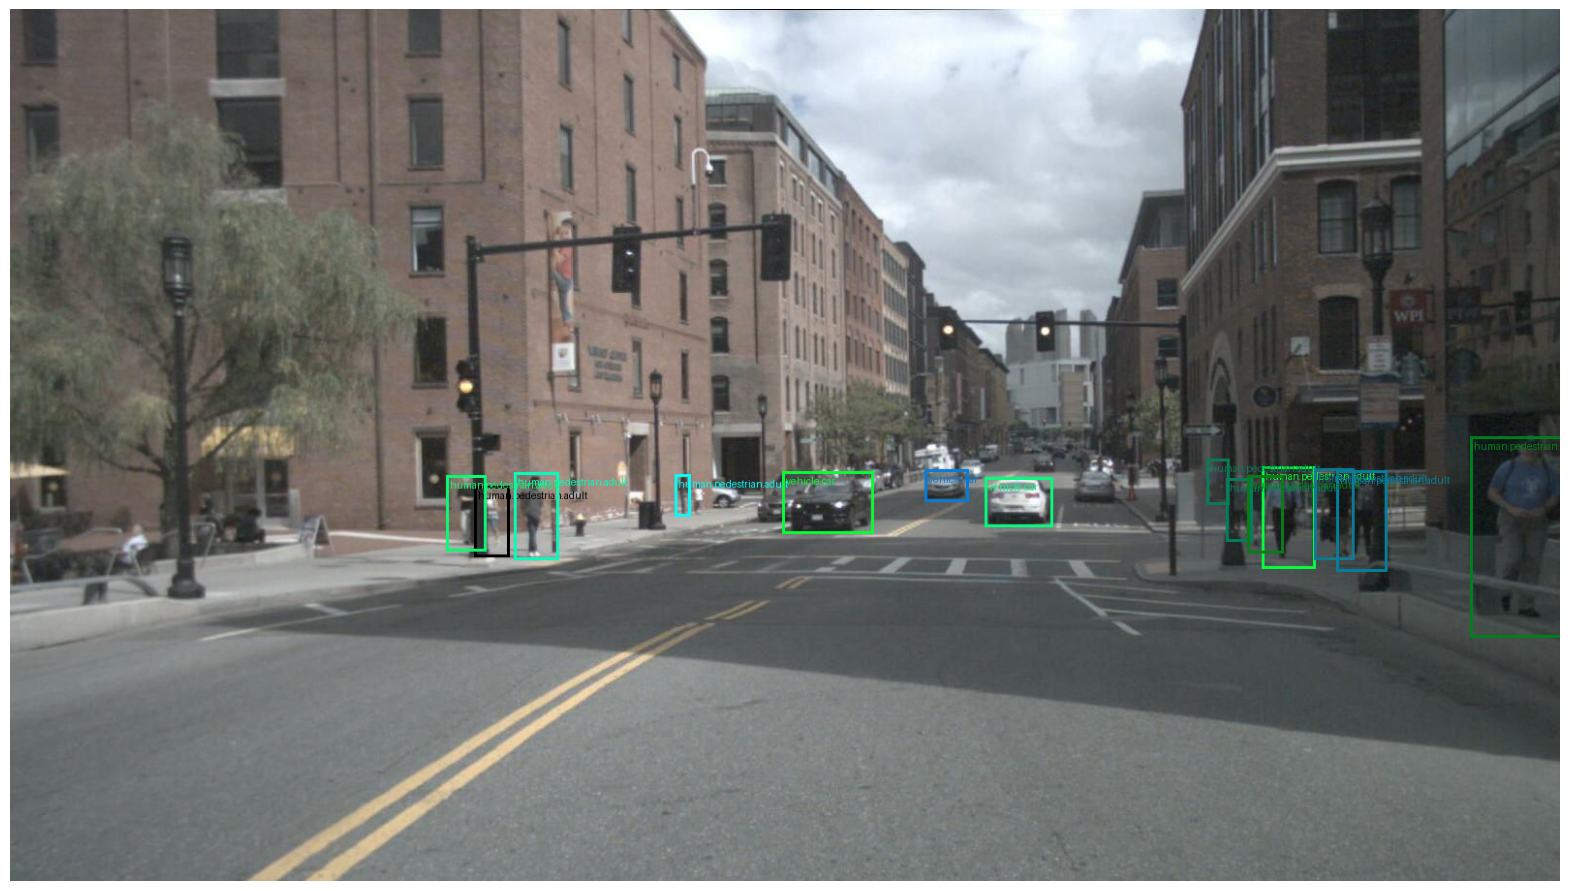

In [8]:
show(draw_bounding_boxes(image_1, torch.tensor(boxesTruth), labels=classesTruth, width=3))

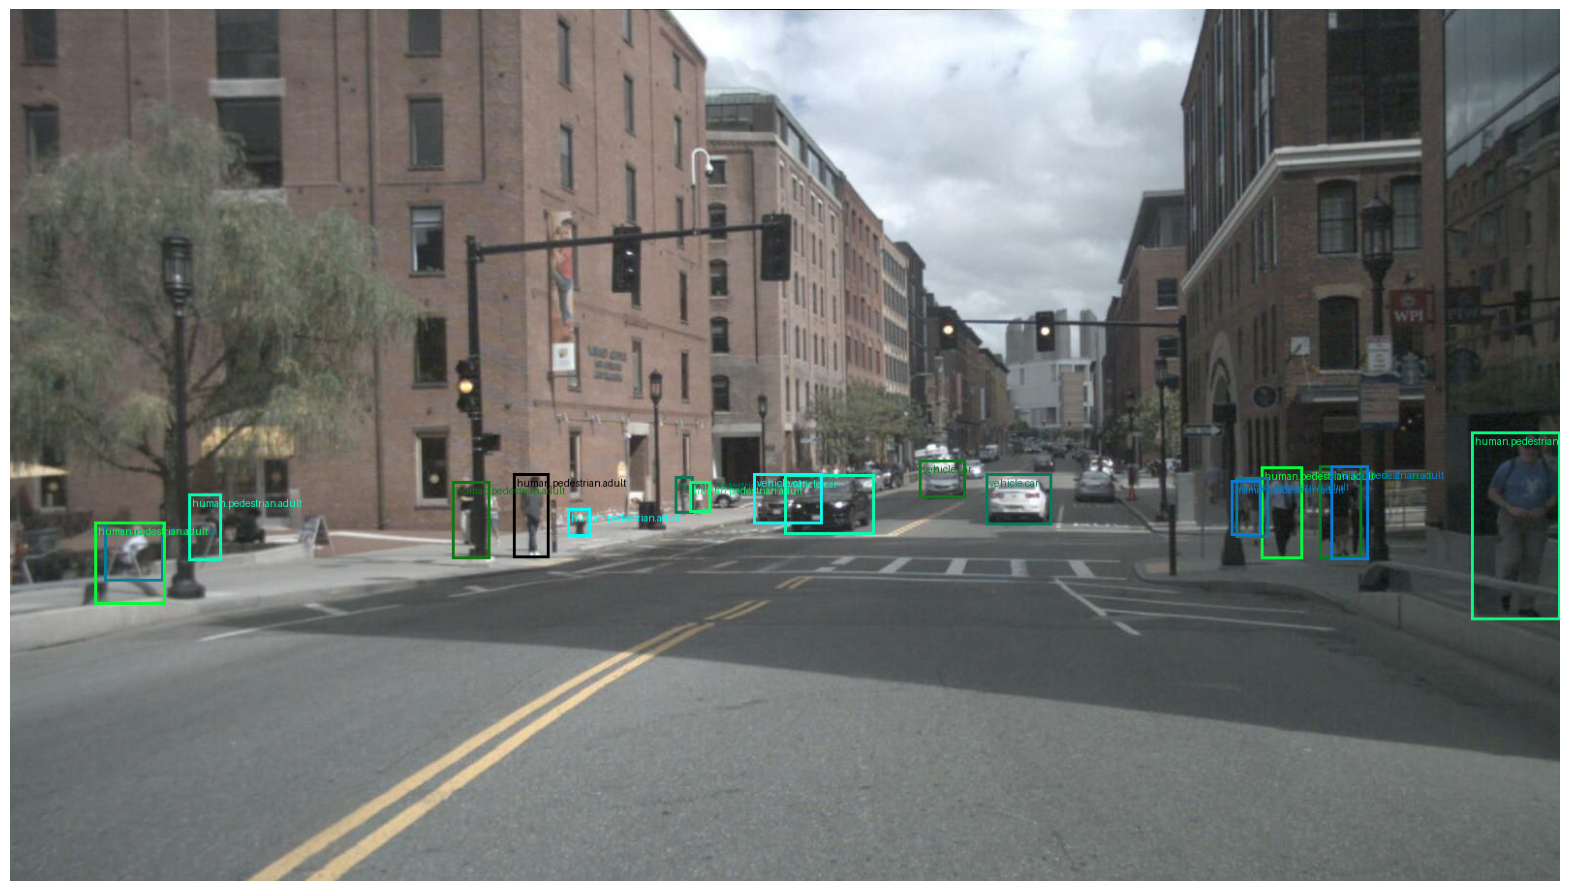

In [9]:
show(draw_bounding_boxes(image_1, torch.tensor(boxes), labels=classes, width=3))

In [10]:
labels = dict({ 'animal' : [],
                'human.pedestrian.adult' : [],
                'human.pedestrian.child' : [],
                'human.pedestrian.construction_worker' : [],
                'human.pedestrian.personal_mobility' : [],
                'human.pedestrian.police_officer' : [],
                'human.pedestrian.stroller' : [],
                'human.pedestrian.wheelchair' : [],
                'movable_object.barrier' : [],
                'movable_object.debris' : [],
                'movable_object.pushable_pullable' : [],
                'movable_object.trafficcone' : [],
                'static_object.bicycle_rack' : [],
                'vehicle.bicycle' : [],
                'vehicle.bus.bendy' : [],
                'vehicle.bus.rigid' : [],
                'vehicle.car' : [],
                'vehicle.construction' : [],
                'vehicle.emergency.ambulance' : [],
                'vehicle.emergency.police' : [],
                'vehicle.motorcycle' : [],
                'vehicle.trailer' : [],
                'vehicle.truck' : [],
                'total': []
              })
for i in labels:
    for j in range(0, 102):
        labels[i].append({'TP' : 0, 'FP' : 0, 'FN' : 0, 'Precision' : 0, 'Recall' : 0, 'Accuracy' : 0, 'IoU' : 0})

In [11]:
#print (labels)

In [ ]:
data = json.load(open('../../jsons/detections.json'))

TP_per_Threshold = []
FP_per_Threshold = []
FN_per_Threshold = []
IoUQuantity_per_Threshold = []
IoUTotal_per_Threshold = []

Accuracy_per_Threshold = []
Precision_per_Threshold = []
Recall_per_Threshold = []
MeanIoU_per_Threshold = []
F1_per_Threshold = []

IoUThresholds = []

IoUThreshold = Decimal('0.00')

while IoUThreshold <= 1:
    print(IoUThreshold)
    TP, FP, FN = 0, 0, 0
    IoUQuantity, IoUTotal = 0, 0
    for tokens in data:
        sample_data, image_1 = load_nuscenes_image(tokens)
        boxesTruth, classesTruth = get_2D_boxes_from_sample_data(nusc, tokens, visibilities=['4'])
        boxes = list(data[tokens]['boxes'])
        classes = list(data[tokens]['labels'])
        for i in list(boxesTruth):
            pos, IoU = 0, 0
        
            for j in boxes:
                currentIoU = get_iou(i, j)
        
                if currentIoU > IoU:
                    pos, IoU = boxes.index(j), currentIoU
        
            posTruth = boxesTruth.index(i)
            
            if IoU > IoUThreshold and classesTruth[posTruth] == classes[pos]:
                labels[classes[pos]][int(IoUThreshold * 100)]['TP'] += 1
                labels['total'][int(IoUThreshold * 100)]['TP'] += 1
                labels['total'][int(IoUThreshold * 100)]['IoU'] += IoU
                classesTruth.pop(posTruth)
                boxesTruth.pop(posTruth)
                classes.pop(pos)
                boxes.pop(pos)

        for fn in classesTruth:
            labels[fn][int(IoUThreshold * 100)]['FN'] += 1
            labels['total'][int(IoUThreshold * 100)]['FN'] += 1

        for fp in classes:
            labels[fp][int(IoUThreshold * 100)]['FP'] += 1
            labels['total'][int(IoUThreshold * 100)]['FP'] += 1

    for i in labels:
        labels[i][int(IoUThreshold * 100)]['Precision'] = labels[i][int(IoUThreshold * 100)]['TP'] / max((labels[i][int(IoUThreshold * 100)]['TP'] + labels[i][int(IoUThreshold * 100)]['FP']), 1)
        labels[i][int(IoUThreshold * 100)]['Recall'] = labels[i][int(IoUThreshold * 100)]['TP'] / max((labels[i][int(IoUThreshold * 100)]['TP'] + labels[i][int(IoUThreshold * 100)]['FN']), 1)
        labels[i][int(IoUThreshold * 100)]['Accuracy'] = labels[i][int(IoUThreshold * 100)]['TP'] / max((labels[i][int(IoUThreshold * 100)]['TP'] + labels[i][int(IoUThreshold * 100)]['FP'] + labels[i][int(IoUThreshold * 100)]['FN']), 1)
    #F1_per_Threshold.append((2 * Precision_per_Threshold[-1] * Recall_per_Threshold[-1]) / max((Precision_per_Threshold[-1] + Recall_per_Threshold[-1]), 1))
    IoUThreshold += Decimal('0.01')

0.00
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.10
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.20
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.30
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.40
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.50
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.60
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.70
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78


In [ ]:
print(labels['total'][:2])

In [ ]:
plt.plot([data['Recall'] for data in labels['total'][:-1]], [data['Precision'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
plt.show()

In [ ]:
plt.plot([data['Accuracy'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('accuracy per IoU threshold')
plt.ylabel('accuracy')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['Precision'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('precision per IoU threshold')
plt.ylabel('precision')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['Recall'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('recall per IoU threshold')
plt.ylabel('recall')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['IoU'] / max(1, data['TP']) for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('meanIoU per IoU threshold')
plt.ylabel('meanIoU')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([2 * data['Precision'] * data['Recall'] / max(1, data['Precision'] + data['Recall']) for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('F1 per IoU threshold')
plt.ylabel('F1')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['TP'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('TP per IoU threshold')
plt.ylabel('TP')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['FP'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('FP per IoU threshold')
plt.ylabel('FP')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
plt.plot([data['FN'] for data in labels['total'][:-1]], linewidth=4, color="red")
plt.title('FN per IoU threshold')
plt.ylabel('FN')
plt.xlabel('IoU threshold')
plt.show()

In [ ]:
data = json.load(open('../../jsons/detections.json'))
_, image1 = load_nuscenes_image('a4f0ea2892094f4586a0e2c84f456d8e')
_, image2 = load_nuscenes_image('332299caf93f4f37874d93def6c7bf46')
_, image3 = load_nuscenes_image('13b3848fba3442f58870664d973fcb3f')
_, image4 = load_nuscenes_image('4c5917e14f224fa2a0bd3bd182f8a3d8')

boxesT_before_img1, classesT_before_img1 = get_2D_boxes_from_sample_data(nusc, 'a4f0ea2892094f4586a0e2c84f456d8e', visibilities=['4'])
boxesT_before_img2, classesT_before_img2 = get_2D_boxes_from_sample_data(nusc, '332299caf93f4f37874d93def6c7bf46', visibilities=['4'])
boxesT_before_img3, classesT_before_img3 = get_2D_boxes_from_sample_data(nusc, '13b3848fba3442f58870664d973fcb3f', visibilities=['4'])
boxesT_before_img4, classesT_before_img4 = get_2D_boxes_from_sample_data(nusc, '4c5917e14f224fa2a0bd3bd182f8a3d8', visibilities=['4'])

boxes_before_img1, classes_before_img1 = list(data['a4f0ea2892094f4586a0e2c84f456d8e']['boxes']), list(data['a4f0ea2892094f4586a0e2c84f456d8e']['labels'])
boxes_before_img2, classes_before_img2 = list(data['332299caf93f4f37874d93def6c7bf46']['boxes']), list(data['332299caf93f4f37874d93def6c7bf46']['labels'])
boxes_before_img3, classes_before_img3 = list(data['13b3848fba3442f58870664d973fcb3f']['boxes']), list(data['13b3848fba3442f58870664d973fcb3f']['labels'])
boxes_before_img4, classes_before_img4 = list(data['4c5917e14f224fa2a0bd3bd182f8a3d8']['boxes']), list(data['4c5917e14f224fa2a0bd3bd182f8a3d8']['labels'])

In [ ]:
data = json.load(open('../../jsons/detections.json'))

TP, FP, FN = 0, 0, 0
IoUThreshold = 0.3
IoUQuantity, IoUTotal = 0, 0

Precisions = []
Recalls = []

for tokens in data:
    sample_data, image_1 = load_nuscenes_image(tokens)
    boxesTruth, classesTruth = get_2D_boxes_from_sample_data(nusc, tokens, visibilities=['4'])
    boxes = list(data[tokens]['boxes'])
    classes = list(data[tokens]['labels'])
    for i in list(boxesTruth):
        pos, IoU = 0, 0
    
        for j in boxes:
            currentIoU = get_iou(i, j)
    
            if currentIoU > IoU:
                pos, IoU = boxes.index(j), currentIoU
    
        posTruth = boxesTruth.index(i)
        
        if IoU > IoUThreshold and classesTruth[posTruth] == classes[pos]:
            IoUQuantity, IoUTotal = IoUQuantity + 1, IoUTotal + IoU
            classesTruth.pop(posTruth)
            boxesTruth.pop(posTruth)
            classes.pop(pos)
            boxes.pop(pos)
    
    TP = IoUQuantity
    FP += len(boxes)
    FN += len(boxesTruth)

    if tokens == 'a4f0ea2892094f4586a0e2c84f456d8e':
        boxesT_after_img1, classesT_after_img1 = boxesTruth, classesTruth
        boxes_after_img1, classes_after_img1 = boxes, classes

    if tokens == '332299caf93f4f37874d93def6c7bf46':
        boxesT_after_img2, classesT_after_img2 = boxesTruth, classesTruth
        boxes_after_img2, classes_after_img2 = boxes, classes

    if tokens == '13b3848fba3442f58870664d973fcb3f':
        boxesT_after_img3, classesT_after_img3 = boxesTruth, classesTruth
        boxes_after_img3, classes_after_img3 = boxes, classes

    if tokens == '4c5917e14f224fa2a0bd3bd182f8a3d8':
        boxesT_after_img4, classesT_after_img4 = boxesTruth, classesTruth
        boxes_after_img4, classes_after_img4 = boxes, classes

Accuracy = TP / (TP + FP + FN)
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
MeanIoU = IoUTotal / max(IoUQuantity, 1)
F1 = 2 * Precision * Recall / max((Precision + Recall), 1)

print ("Accuracy: "+str(Accuracy))
print ("Precision: "+str(Precision))
print ("Recall: "+str(Recall))
print ("MeanIoU: "+str(MeanIoU))
print ("F1: "+str(F1))

In [ ]:
if len(boxesT_after_img1) > 0:
    show(draw_bounding_boxes(image1, torch.tensor(boxesT_after_img1), labels=classesT_after_img1, width=3))
else:
    show(image1)

In [ ]:
if len(boxes_after_img1) > 0:
    show(draw_bounding_boxes(image1, torch.tensor(boxes_after_img1), labels=classes_after_img1, width=3))
else:
    show(image1)

In [ ]:
if len(boxesT_after_img2) > 0:
    show(draw_bounding_boxes(image2, torch.tensor(boxesT_after_img2), labels=classesT_after_img2, width=3))
else:
    show(image2)

In [ ]:
if len(boxes_after_img2) > 0:
    show(draw_bounding_boxes(image2, torch.tensor(boxes_after_img2), labels=classes_after_img2, width=3))
else:
    show(image2)

In [ ]:
if len(boxesT_after_img3) > 0:
    show(draw_bounding_boxes(image3, torch.tensor(boxesT_after_img3), labels=classesT_after_img3, width=3))
else:
    show(image3)

In [ ]:
if len(boxes_after_img3) > 0:
    show(draw_bounding_boxes(image3, torch.tensor(boxes_after_img3), labels=classes_after_img3, width=3))
else:
    show(image3)